In [740]:
import os
import pandas as pd
import numpy as np

from sklearn.svm import SVR
import matplotlib.pyplot as plt

from fireTS.models import NARX, DirectAutoRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# DirectAutoRegressor - single input

In [742]:
df = pd.read_csv('data/2018_1hourdata.csv')
X = df['EASH_WASH_in'].values
size = int(len(X) * 0.8)

train, test = X[0:size], X[size:len(X)]
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))
train = scaler.transform(train.reshape(-1, 1)).reshape(1, -1)[0]
test = scaler.transform(test.reshape(-1, 1)).reshape(1, -1)[0]

r2_list = []
mae_list = []
rmse_list = []
mse_list = []
ypred_df = pd.DataFrame()
narx_mdl = DirectAutoRegressor(LinearRegression(), auto_order=24, exog_order=[24], exog_delay=[0], pred_step=1)
narx_mdl.fit(train[:,None], train)
ypred_df['y'] = test
for i in range(1,25):
    ypred_narx = narx_mdl.predict(test[:, None], test)
    ypred_df[i] = ypred_narx
    ypred_narx[0:24] = test[0:24]
    test = ypred_narx

In [743]:
r2_list = []
for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][48:]
    ypred = ypred_df.iloc[:,horizon][48:] 
    r2_list.append(r2_score(yobs, ypred))

In [746]:
r2_list

[0.7839361665329955,
 0.621128738618512,
 0.5107894271028044,
 0.4199585076798773,
 0.3413898705620574,
 0.26421538898136077,
 0.19394988279489622,
 0.12876668622450527,
 0.07581563993275331,
 0.022102662723126554,
 -0.02063038783131077,
 -0.06556315833027093,
 -0.10026169619413161,
 -0.1348960931291705,
 -0.16192092994677565,
 -0.1878883206633768,
 -0.21156681735321126,
 -0.232311194587006,
 -0.2530218403793305,
 -0.2679854427575412,
 -0.28815052759181237,
 -0.3008468235044961,
 -0.3208459612590824,
 -0.33029802802377906]

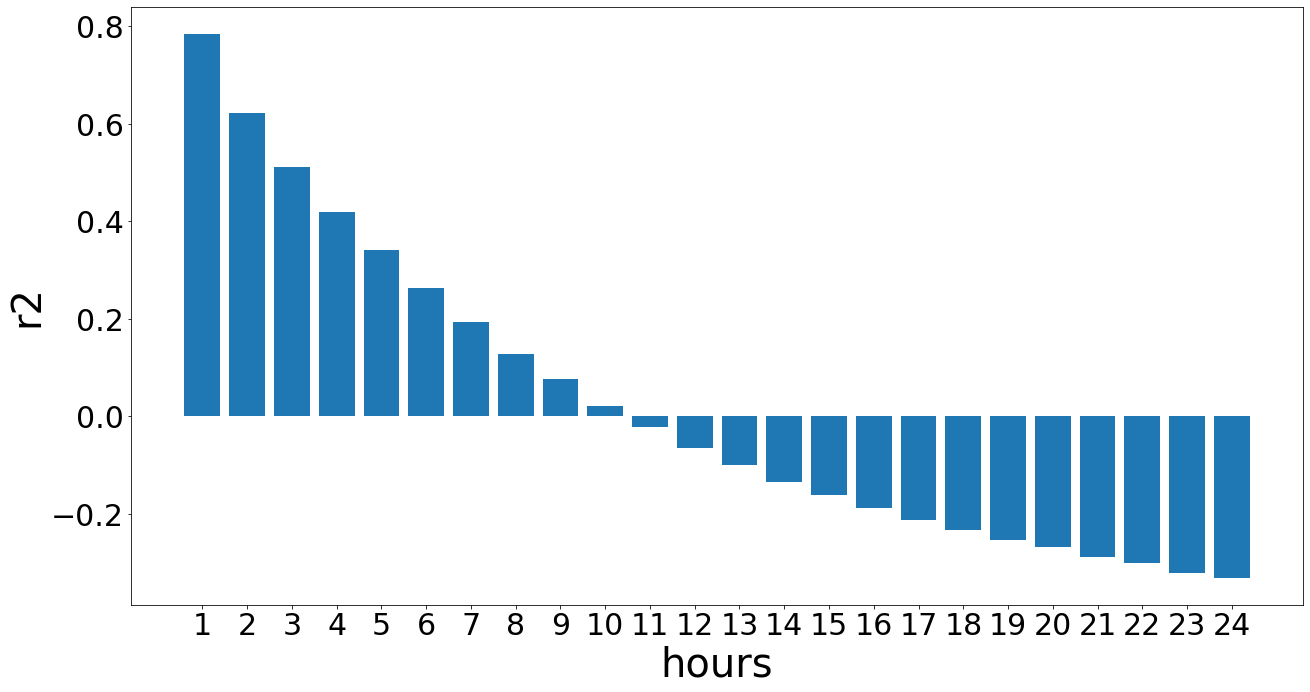

In [745]:
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()

# DirectAutoRegressor - exogenous inputs

In [754]:
df = pd.read_csv('data/2018_1hourdata.csv')

in_nodes = df.filter(regex=('_' + 'WASH' + '_.*in$'))#.head(n=4)

cols = [ 'CHIC_WASH_in', 'PPPL_WASH_in', 'CERN-513_WASH_in',
       'NASH_WASH_in', 'AOFA_WASH_in', 'ATLA_WASH_in'] # 'EASH_WASH_in',

#in_nodes = in_nodes[cols]

size = int(len(X) * 0.8)

ytrain = in_nodes['EASH_WASH_in'].iloc[:size]
Xtrain = in_nodes.loc[:, cols].iloc[:size, :]

ytest = in_nodes['EASH_WASH_in'].iloc[size:-1]
Xtest = in_nodes.loc[:, cols].iloc[size:-1, :]

In [755]:
for i in range(len(cols)):
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(Xtrain.iloc[:,i].values.reshape(-1, 1))
    Xtrain.iloc[:,i] = scaler.transform(Xtrain.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]
    Xtest.iloc[:,i] = scaler.transform(Xtest.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]


In [756]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(ytrain.values.reshape(-1, 1))
ytrain = scaler.transform(ytrain.values.reshape(-1, 1)).reshape(1, -1)[0]
ytest = scaler.transform(ytest.values.reshape(-1, 1)).reshape(1, -1)[0]

In [757]:
narx_mdl = DirectAutoRegressor(LinearRegression(), auto_order=24, exog_order=Xtrain.shape[1]*[24], exog_delay=Xtrain.shape[1]*[0], pred_step=1)
narx_mdl.fit(Xtrain, ytrain)
ypred_df = pd.DataFrame()
ypred_df['y'] = ytest
for i in range(1,25):
    ypred_narx = narx_mdl.predict(Xtest, ytest)
    ypred_df[i] = ypred_narx
    ypred_narx[0:24] = ytest[0:24]
    ytest = ypred_narx

In [758]:
r2_list = []
for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][48:]
    ypred = ypred_df.iloc[:,horizon][48:] 
    r2_list.append(r2_score(yobs, ypred))

In [759]:
r2_list

[0.7815626629391466,
 0.618216117203285,
 0.5063316360705843,
 0.41529168879453593,
 0.33525327311565223,
 0.2588121989377249,
 0.1884790171164148,
 0.12454908559611999,
 0.07101286959081676,
 0.01767413112488392,
 -0.02695851330442922,
 -0.07231234431237032,
 -0.11013048694051664,
 -0.14652389531682086,
 -0.1782542465461674,
 -0.20698873119107009,
 -0.23566035167253707,
 -0.25910369201687566,
 -0.28462202596852904,
 -0.3026278939620377,
 -0.3269484898762052,
 -0.3423619462943568,
 -0.36525800786111606,
 -0.3771496986922622]

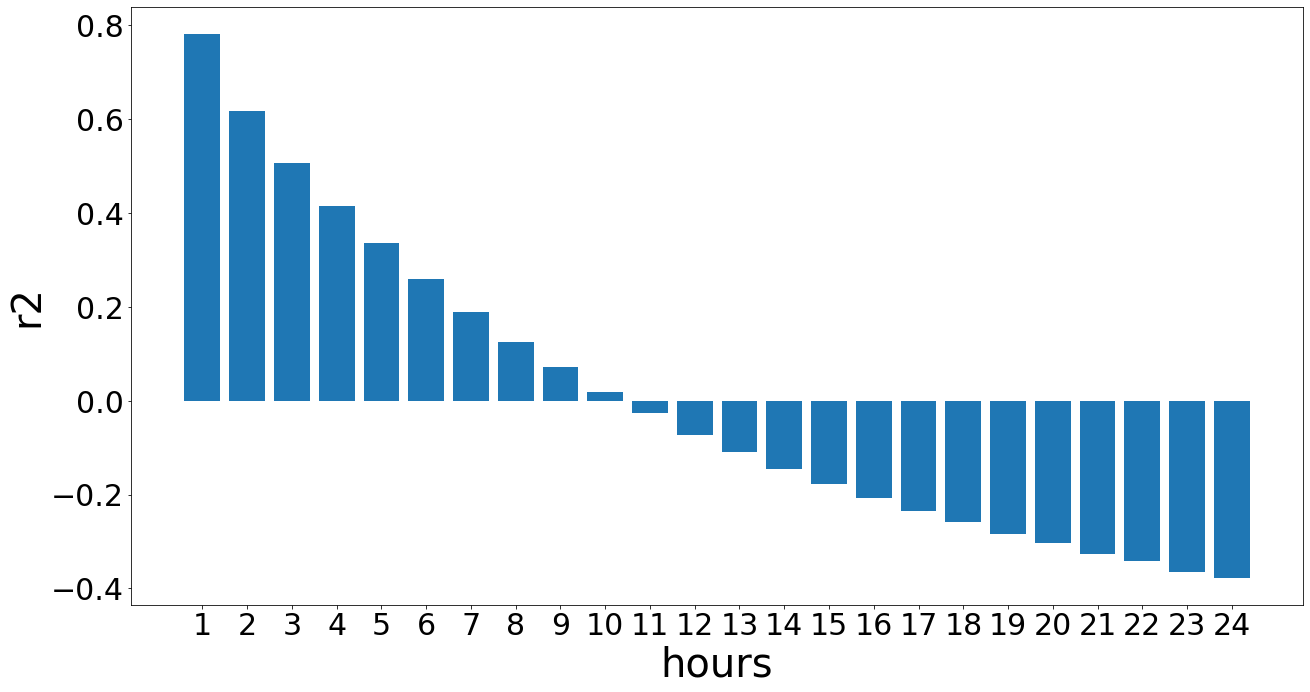

In [760]:
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()

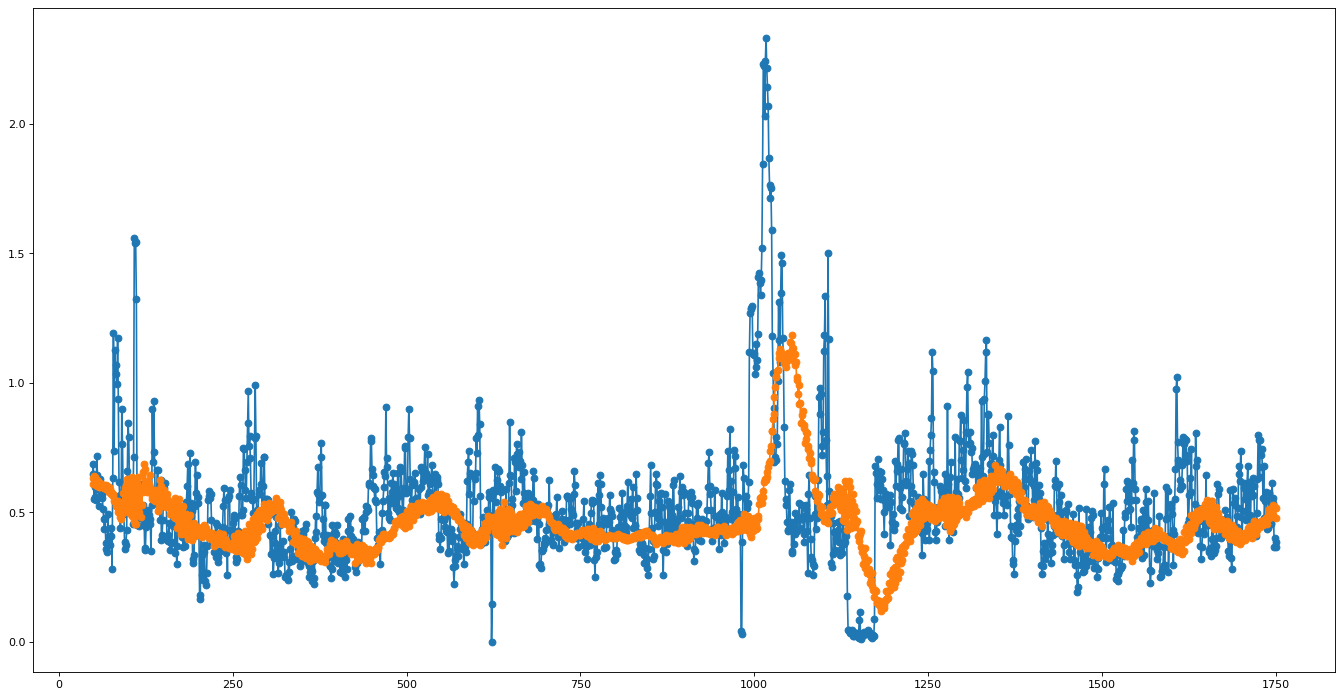

In [662]:
horizon = 12
yobs = ypred_df.iloc[:,0][48:]
ypred = ypred_df.iloc[:,horizon][48:] 
plt.figure(figsize=(21, 11), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(yobs,'o-', label='input')#, linewidth=6)
plt.plot(ypred, 'o-',  label='24-step-ahead prediction')#, linewidth=6)

# DirectAutoRegressor - SVR(kernel='rbf')

In [663]:
df = pd.read_csv('data/2018_1hourdata.csv')
X = df['EASH_WASH_in'].values
size = int(len(X) * 0.8)

train, test = X[0:size], X[size:len(X)]
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))
train = scaler.transform(train.reshape(-1, 1)).reshape(1, -1)[0]
test = scaler.transform(test.reshape(-1, 1)).reshape(1, -1)[0]

r2_list = []
mae_list = []
rmse_list = []
mse_list = []
ypred_df = pd.DataFrame()
narx_mdl = DirectAutoRegressor(SVR(kernel='rbf'), auto_order=24, exog_order=[24], exog_delay=[0], pred_step=1)
narx_mdl.fit(train[:,None], train)
ypred_df['y'] = test
for i in range(1,25):
    ypred_narx = narx_mdl.predict(test[:, None], test)
    ypred_df[i] = ypred_narx
    ypred_narx[0:24] = test[0:24]
    test = ypred_narx

/Users/tanwimallick/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


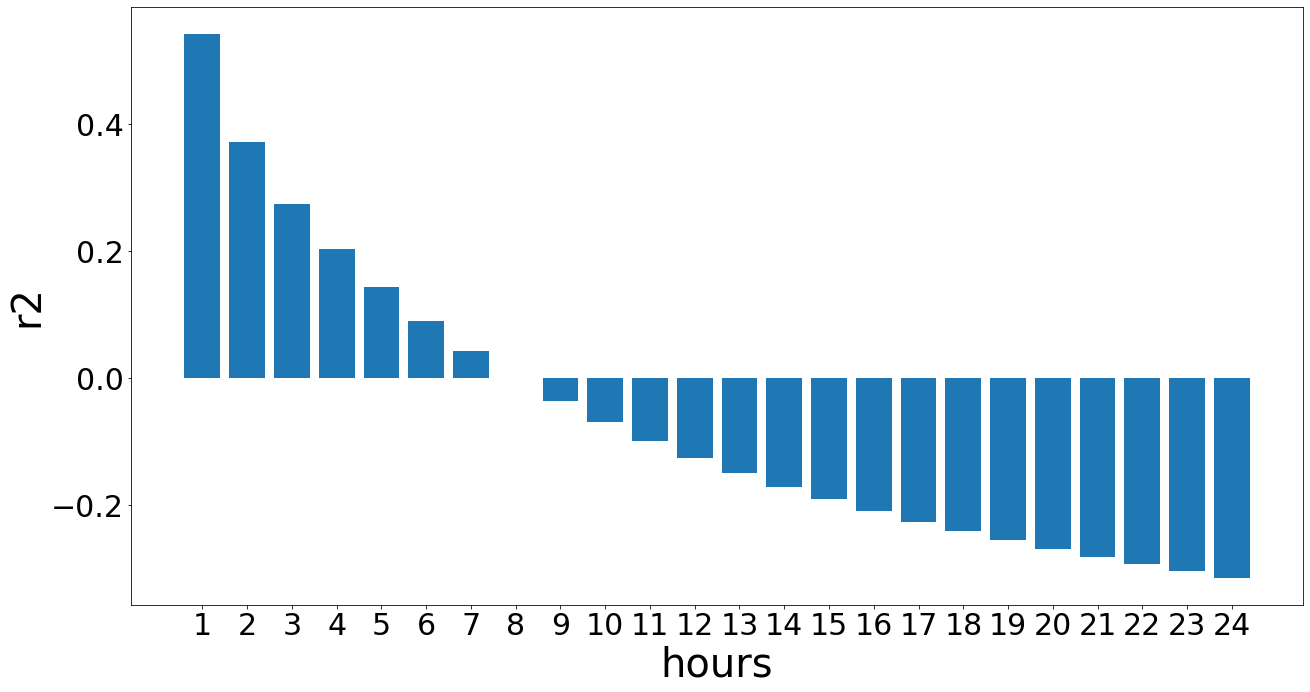

In [664]:
r2_list = []
for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][48:]
    ypred = ypred_df.iloc[:,horizon][48:] 
    r2_list.append(r2_score(yobs, ypred))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()

# DirectAutoRegressor -  RandomForestRegressor()

In [668]:
df = pd.read_csv('data/2018_1hourdata.csv')
X = df['EASH_WASH_in'].values
size = int(len(X) * 0.8)

train, test = X[0:size], X[size:len(X)]
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))
train = scaler.transform(train.reshape(-1, 1)).reshape(1, -1)[0]
test = scaler.transform(test.reshape(-1, 1)).reshape(1, -1)[0]

r2_list = []
mae_list = []
rmse_list = []
mse_list = []
ypred_df = pd.DataFrame()
narx_mdl = DirectAutoRegressor(RandomForestRegressor(), auto_order=24, exog_order=[24], exog_delay=[0], pred_step=1)
narx_mdl.fit(train[:,None], train)
ypred_df['y'] = test
for i in range(1,25):
    ypred_narx = narx_mdl.predict(test[:, None], test)
    ypred_df[i] = ypred_narx
    ypred_narx[0:24] = test[0:24]
    test = ypred_narx

/Users/tanwimallick/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


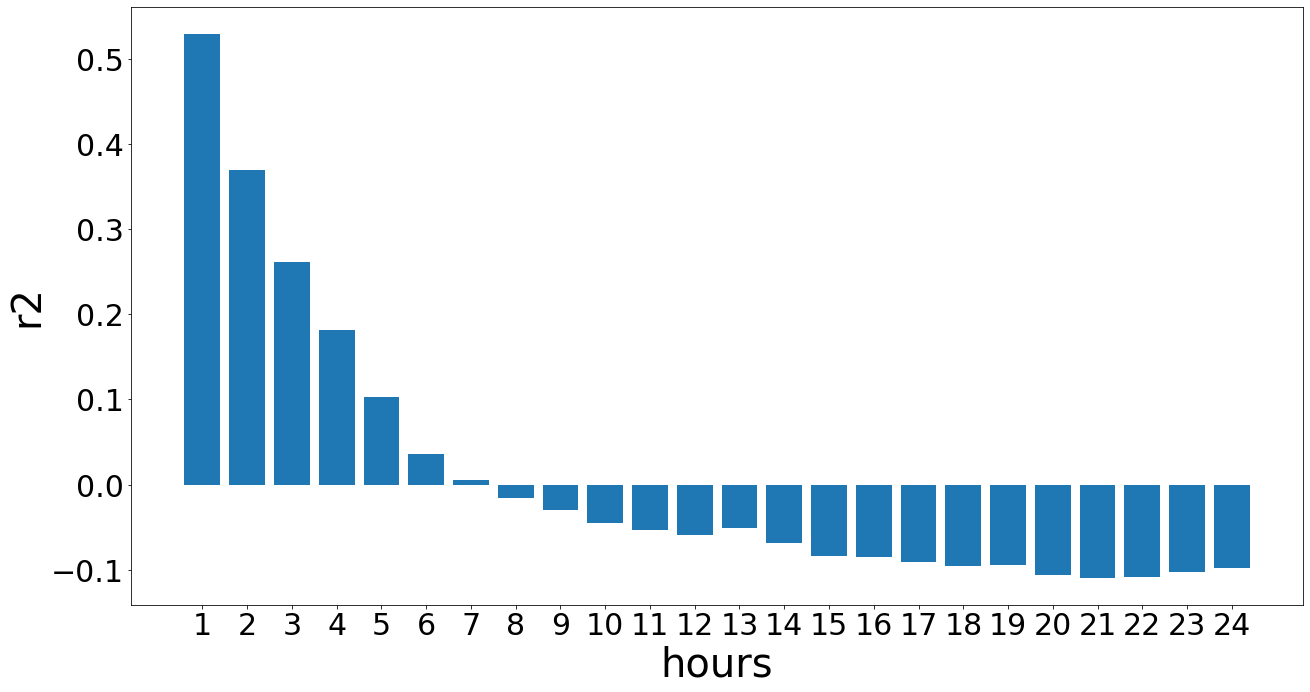

In [669]:
r2_list = []
for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][48:]
    ypred = ypred_df.iloc[:,horizon][48:] 
    r2_list.append(r2_score(yobs, ypred))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()

# DirectAutoRegressor - DecisionTreeRegression()

In [674]:
df = pd.read_csv('data/2018_1hourdata.csv')
X = df['EASH_WASH_in'].values
size = int(len(X) * 0.8)

train, test = X[0:size], X[size:len(X)]
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))
train = scaler.transform(train.reshape(-1, 1)).reshape(1, -1)[0]
test = scaler.transform(test.reshape(-1, 1)).reshape(1, -1)[0]

r2_list = []
mae_list = []
rmse_list = []
mse_list = []
ypred_df = pd.DataFrame()
narx_mdl = DirectAutoRegressor(DecisionTreeRegressor(), auto_order=24, exog_order=[24], exog_delay=[0], pred_step=1)
narx_mdl.fit(train[:,None], train)
ypred_df['y'] = test
for i in range(1,25):
    ypred_narx = narx_mdl.predict(test[:, None], test)
    ypred_df[i] = ypred_narx
    ypred_narx[0:24] = test[0:24]
    test = ypred_narx

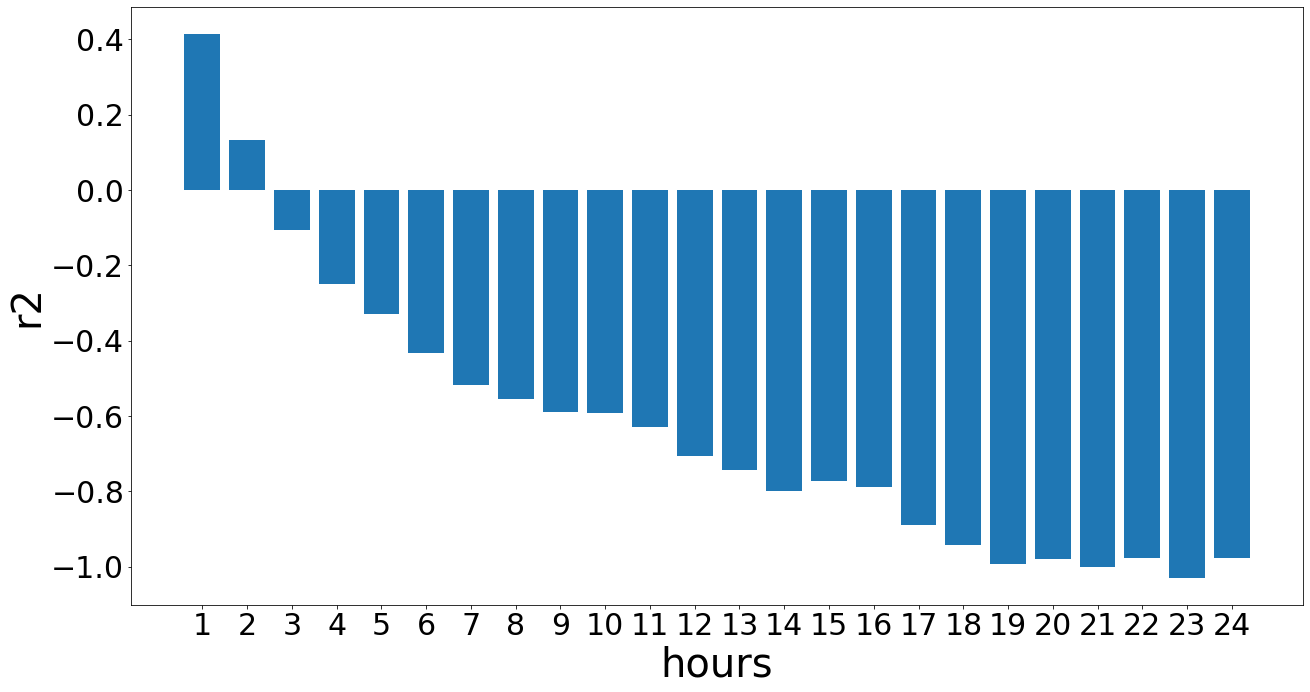

In [675]:
r2_list = []
for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][48:]
    ypred = ypred_df.iloc[:,horizon][48:] 
    r2_list.append(r2_score(yobs, ypred))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()

In [677]:
df = pd.read_csv('data/2018_1hourdata.csv')
X = df['EASH_WASH_in'].values
size = int(len(X) * 0.8)

train, test = X[0:size], X[size:len(X)]
scaler = MinMaxScaler(feature_range=(0, 1)).fit(train.reshape(-1, 1))
train = scaler.transform(train.reshape(-1, 1)).reshape(1, -1)[0]
test = scaler.transform(test.reshape(-1, 1)).reshape(1, -1)[0]

r2_list = []
mae_list = []
rmse_list = []
mse_list = []
ypred_df = pd.DataFrame()
narx_mdl = DirectAutoRegressor(GradientBoostingRegressor(), auto_order=24, exog_order=[24], exog_delay=[0], pred_step=1)
narx_mdl.fit(train[:,None], train)
ypred_df['y'] = test
for i in range(1,25):
    ypred_narx = narx_mdl.predict(test[:, None], test)
    ypred_df[i] = ypred_narx
    ypred_narx[0:24] = test[0:24]
    test = ypred_narx

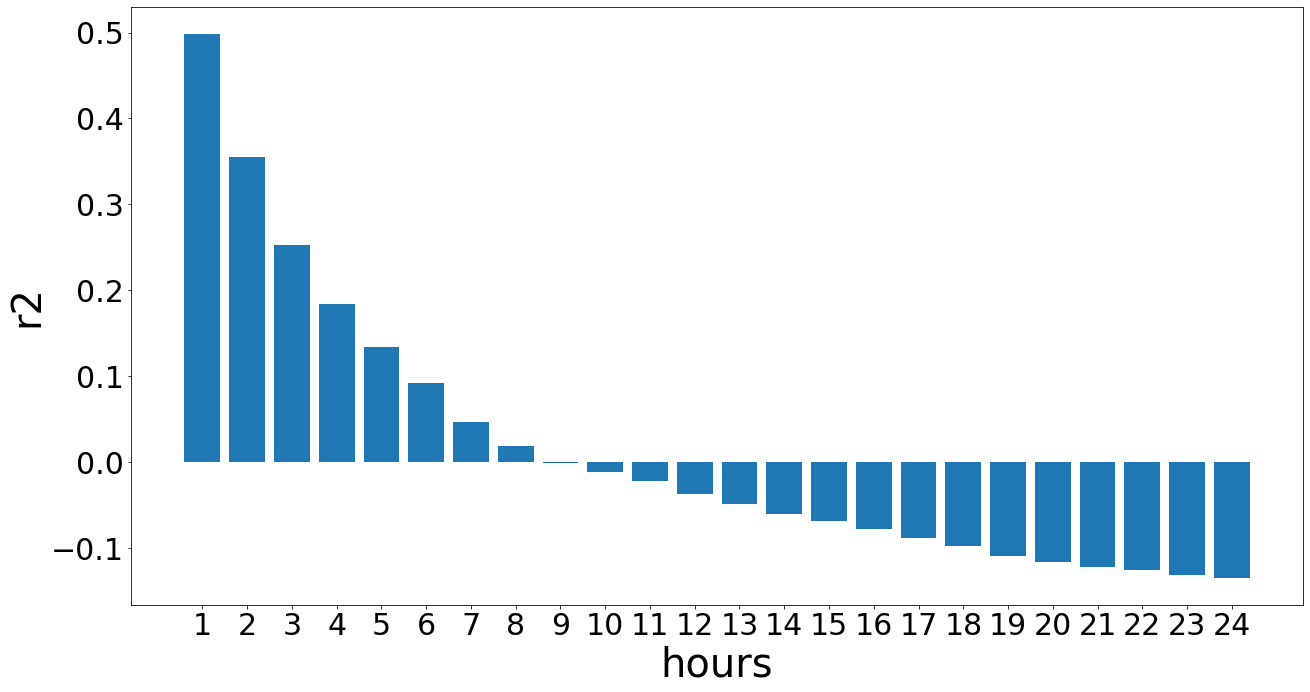

In [678]:
r2_list = []
for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][48:]
    ypred = ypred_df.iloc[:,horizon][48:] 
    r2_list.append(r2_score(yobs, ypred))
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()

# NARX - exogenous inputs

In [761]:
df = pd.read_csv('data/2018_1hourdata.csv')

in_nodes = df.filter(regex=('_' + 'WASH' + '_.*in$'))#.head(n=4)

cols = [ 'CHIC_WASH_in', 'PPPL_WASH_in', 'CERN-513_WASH_in',
       'NASH_WASH_in', 'AOFA_WASH_in', 'ATLA_WASH_in'] # 'EASH_WASH_in',

#in_nodes = in_nodes[cols]

size = int(len(X) * 0.8)

ytrain = in_nodes['EASH_WASH_in'].iloc[:size]
Xtrain = in_nodes.loc[:, cols].iloc[:size, :]

ytest = in_nodes['EASH_WASH_in'].iloc[size:-1]
Xtest = in_nodes.loc[:, cols].iloc[size:-1, :]

In [762]:
for i in range(len(cols)):
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(Xtrain.iloc[:,i].values.reshape(-1, 1))
    Xtrain.iloc[:,i] = scaler.transform(Xtrain.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]
    Xtest.iloc[:,i] = scaler.transform(Xtest.iloc[:,i].values.reshape(-1, 1)).reshape(1, -1)[0]

In [763]:
scaler = MinMaxScaler(feature_range=(0, 1)).fit(ytrain.values.reshape(-1, 1))
ytrain = scaler.transform(ytrain.values.reshape(-1, 1)).reshape(1, -1)[0]
ytest = scaler.transform(ytest.values.reshape(-1, 1)).reshape(1, -1)[0]

In [764]:
narx_mdl = NARX(LinearRegression(), auto_order=24, exog_order=Xtrain.shape[1]*[24], exog_delay=Xtrain.shape[1]*[0])
narx_mdl.fit(Xtrain, ytrain)
ypred_df = pd.DataFrame()
ypred_df['y'] = ytest
for i in range(1,25):
    ypred_narx = narx_mdl.predict(Xtest, ytest, step=1)
    ypred_df[i] = ypred_narx
    
    ypred_narx[0:24] = ytest[0:24]
    ytest = ypred_narx

In [765]:
r2_list = []
for horizon in range(1,25):
    yobs = ypred_df.iloc[:,0][48:]
    ypred = ypred_df.iloc[:,horizon][48:] 
    r2_list.append(r2_score(yobs, ypred))

In [766]:
r2_list

[0.7815626629391466,
 0.618216117203285,
 0.5063316360705843,
 0.41529168879453593,
 0.33525327311565223,
 0.2588121989377249,
 0.1884790171164148,
 0.12454908559611999,
 0.07101286959081676,
 0.01767413112488392,
 -0.02695851330442922,
 -0.07231234431237032,
 -0.11013048694051664,
 -0.14652389531682086,
 -0.1782542465461674,
 -0.20698873119107009,
 -0.23566035167253707,
 -0.25910369201687566,
 -0.28462202596852904,
 -0.3026278939620377,
 -0.3269484898762052,
 -0.3423619462943568,
 -0.36525800786111606,
 -0.3771496986922622]

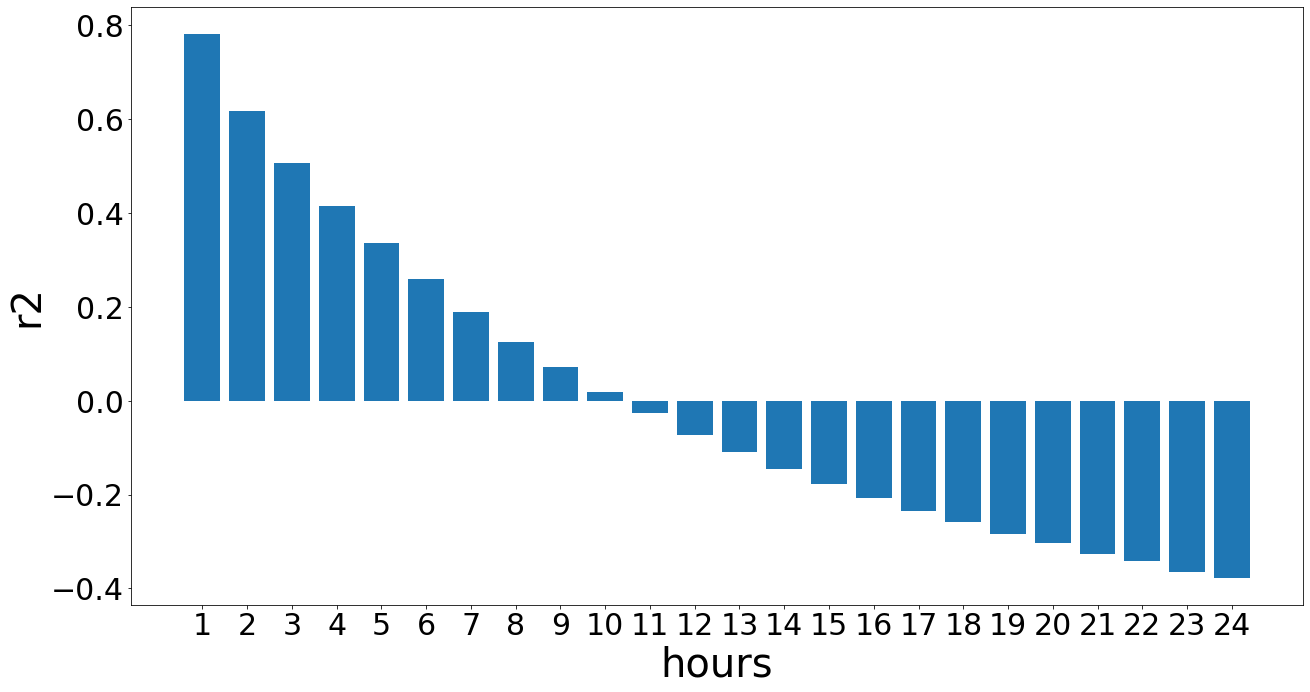

In [767]:
fig = plt.figure(figsize=(21, 11))
plt.yticks(fontsize=30)
plt.xticks(fontsize=30)
langs = list(map(str, list(range(1,25))))
plt.bar(langs,r2_list)
plt.ylabel('r2', fontsize=40)
plt.xlabel('hours', fontsize=40)
plt.show()

# Example 

In [591]:
data = pd.read_csv(os.path.join('.', 'fireTS/examples/data/adolescent#001.csv'))
data = data.set_index('Time')
data.index = pd.to_datetime(data.index)

In [592]:
ytrain = data['CGM'].iloc[:1000]
#Xtrain = data.loc[:, ['insulin', 'CGM']].iloc[:1000, :]
Xtrain = data.loc[:, ['insulin']].iloc[:1000, :]

ytest = data['CGM'].iloc[1000:-1]
#Xtest = data.loc[:, ['insulin', 'CGM']].iloc[1000:-1, :]
Xtest = data.loc[:, ['insulin']].iloc[1000:-1, :]

In [597]:
narx_mdl = NARX(LinearRegression(), auto_order=6, exog_order=[6], exog_delay=[0])

In [598]:
narx_mdl.fit(Xtrain, ytrain)

In [599]:
ypred_narx = narx_mdl.predict(Xtest, ytest, step=6)
ypred_narx = pd.Series(ypred_narx, index=ytest.index)

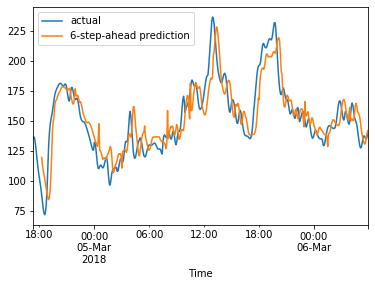

In [600]:
ytest.plot(label='actual')
ypred_narx.plot(label='6-step-ahead prediction')
plt.legend()

In [460]:
direct_mdl = DirectAutoRegressor(LinearRegression(), 
                                 auto_order=6, 
                                 exog_order=[3, 3], 
                                 exog_delay=[0, 0], 
                                 pred_step=6)

In [463]:
direct_mdl.fit(Xtrain, ytrain)
ypred_direct = direct_mdl.predict(Xtest, ytest)
ypred_direct = pd.Series(ypred_direct, index=ytest.index)

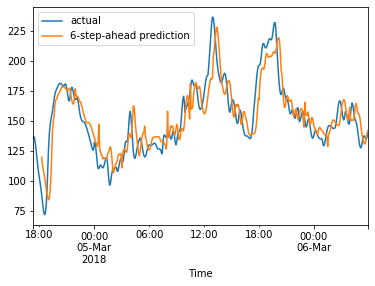

In [464]:
ytest.plot(label='actual')
ypred_direct.plot(label='6-step-ahead prediction')
plt.legend()

In [741]:
# Prediction result in a small window

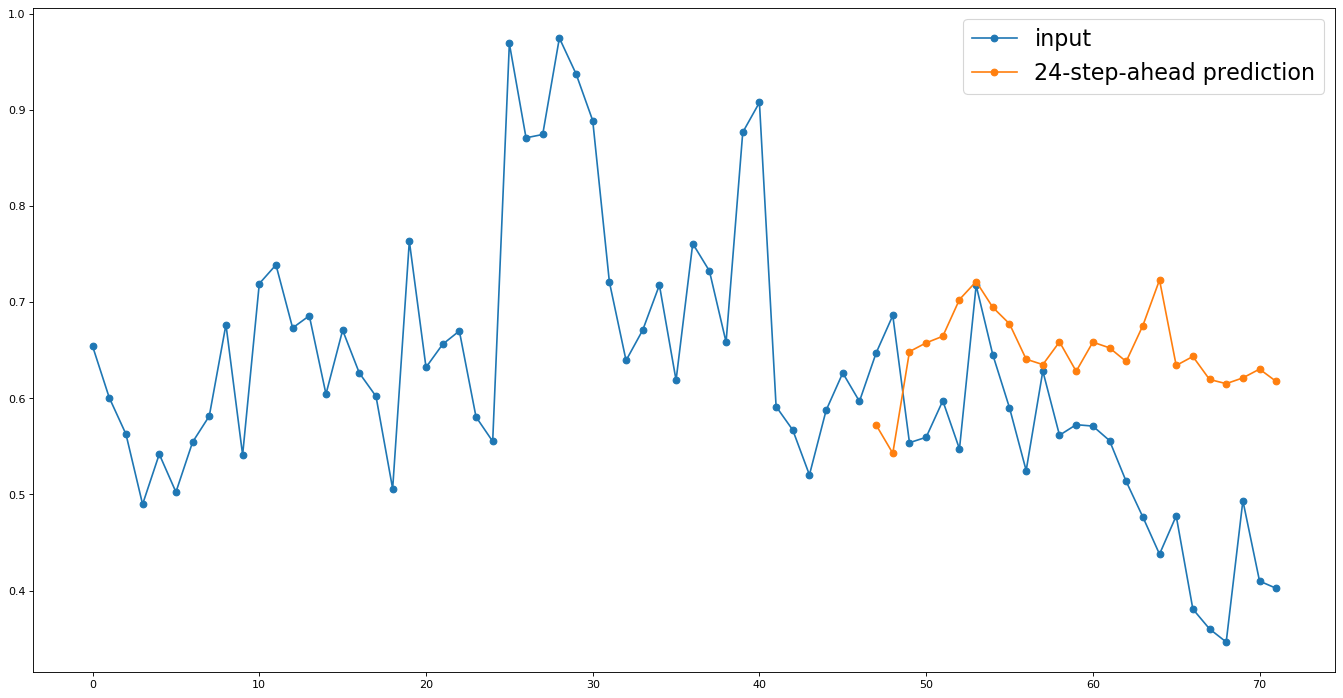

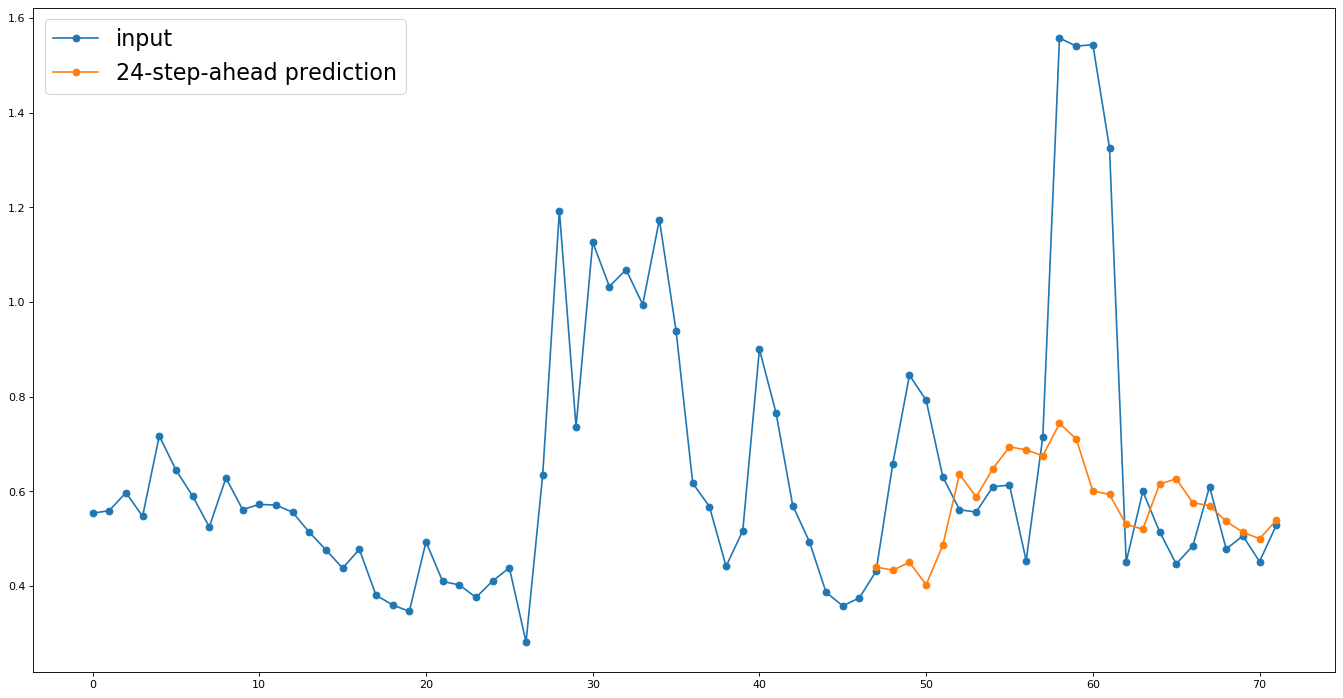

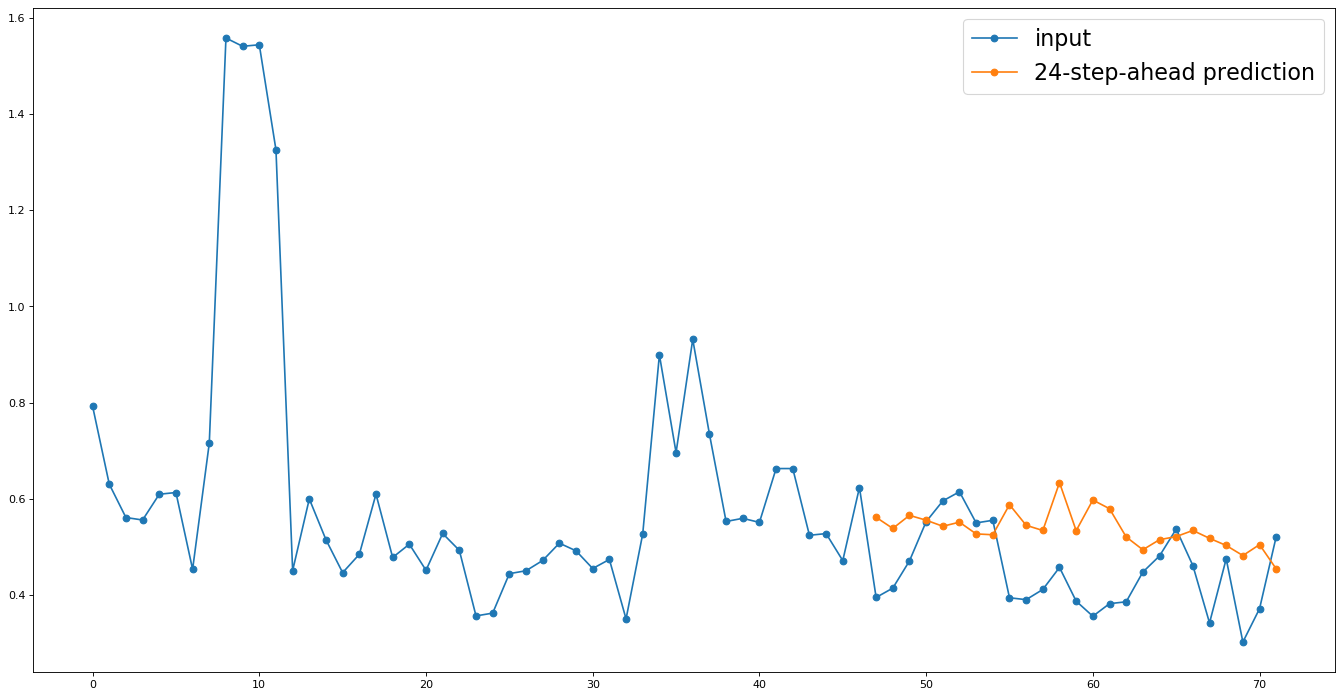

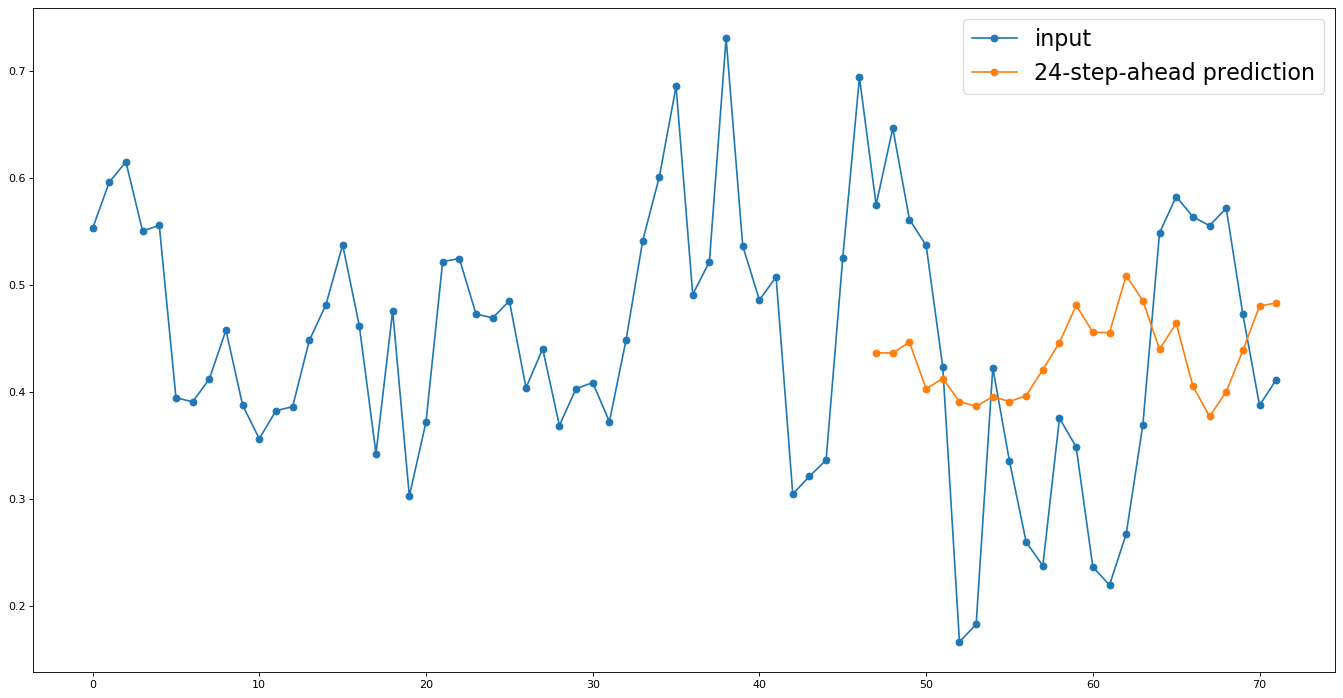

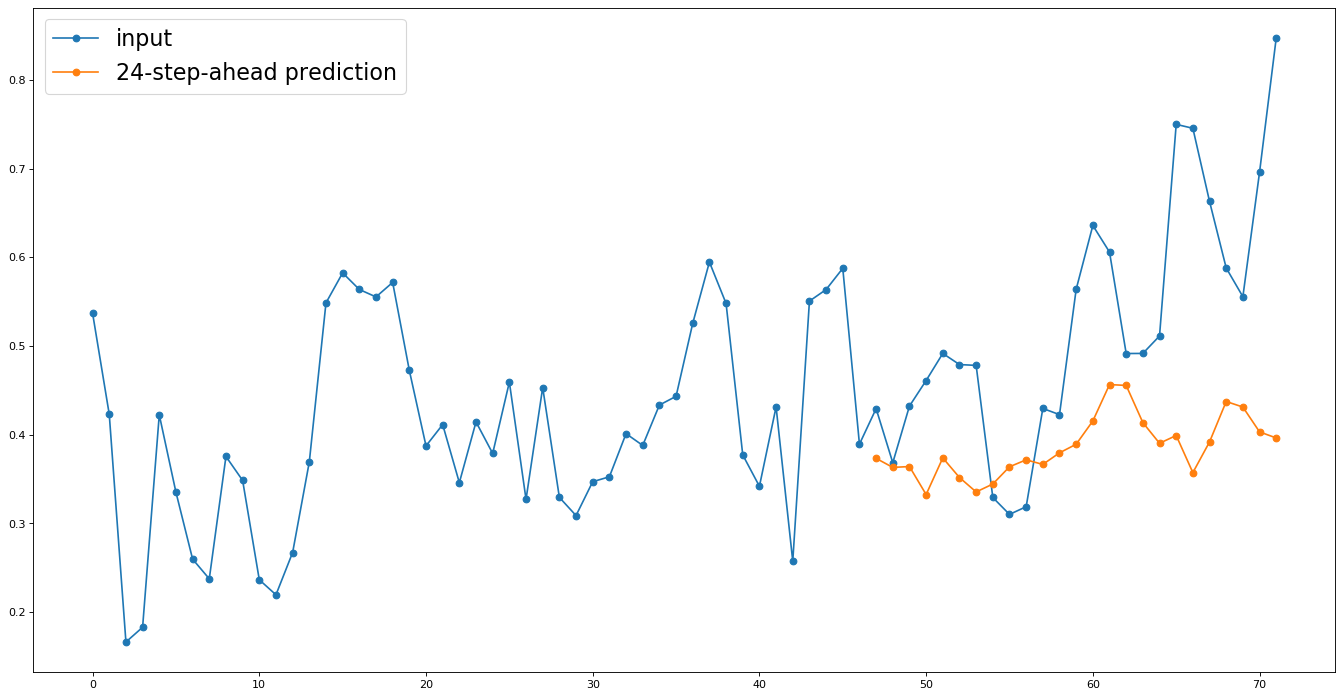

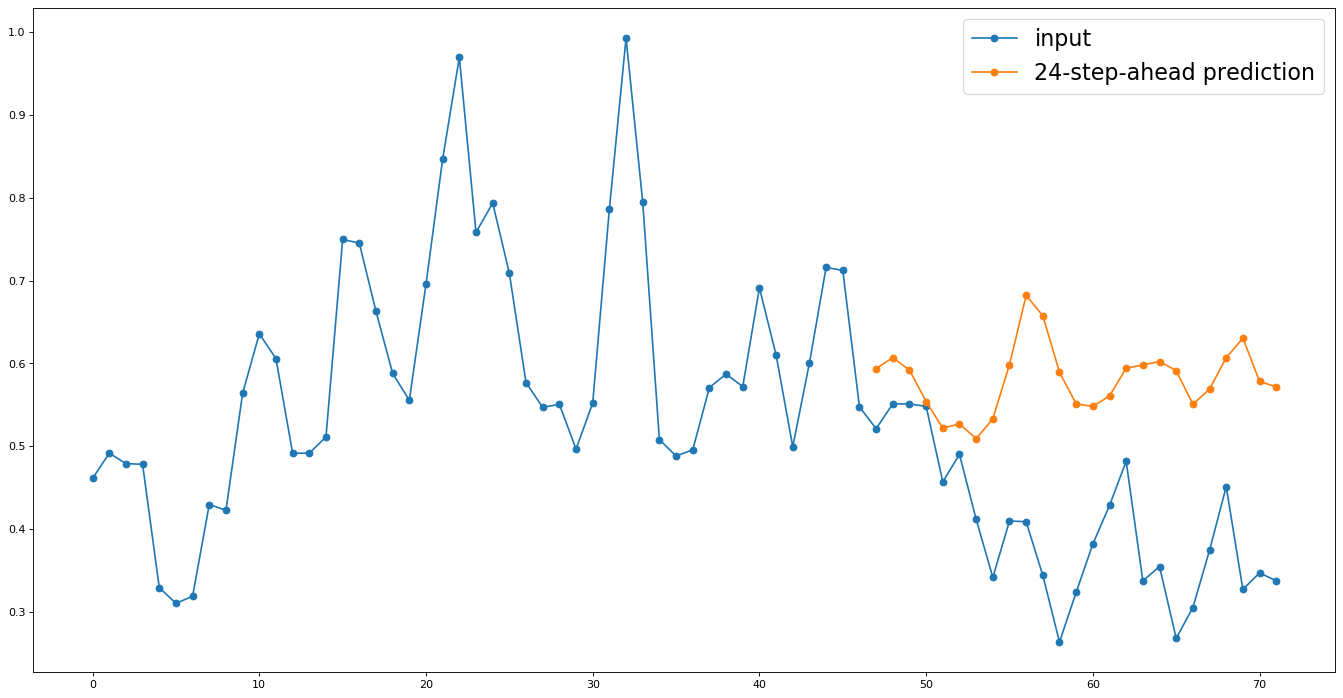

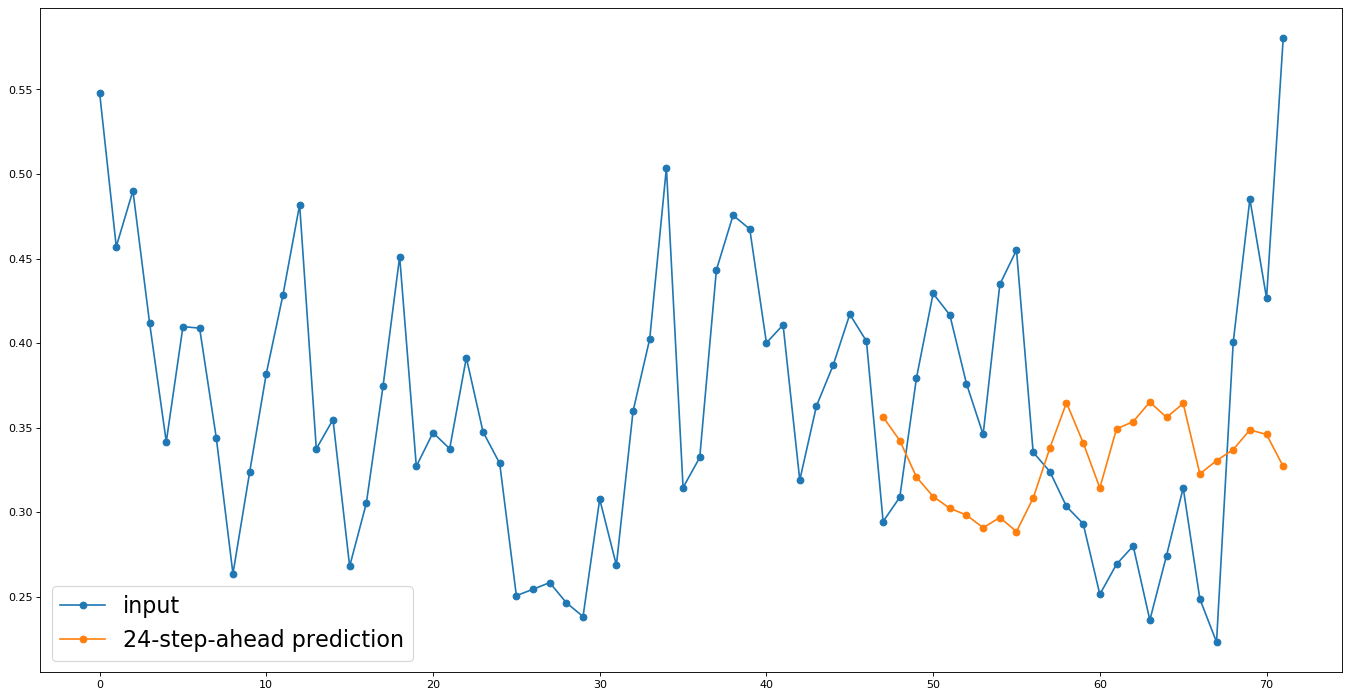

In [458]:
gen_list = [1, 50, 100, 150, 200, 250, 300]
for i in range(len(gen_list)):
    
    start = gen_list[i]
    end = start + 48 + 24
    test_new = test[start:end]
    ypred_narx = narx_mdl.predict(test_new[:, None], test_new)
    
    plt.figure(figsize=(21, 11), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(test_new,'o-', label='input')#, linewidth=6)
    plt.plot(ypred_narx, 'o-',  label='24-step-ahead prediction')#, linewidth=6)
    #ytest.plot(label='actual')
    #ypred_narx.plot(label=str(i)+'-step-ahead prediction')
    plt.legend(fontsize=20)